In [1]:
import itertools
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json

from glob import glob
import os
import functools

from importlib import reload

import utils
import persim

import tifffile as tf
from KDEpy import FFTKDE
import gudhi as gd
from scipy import ndimage,stats,spatial
from sklearn import decomposition, preprocessing

In [2]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.0
rng = np.random.default_rng(seed)
permmethod = stats.PermutationMethod(n_resamples=999, random_state=rng)

Cmap='plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
s = 50
alphaNmin = 0.1
alphaNmax = 10

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00']
cmap = ['PuBu_r', 'Greens_r', 'Blues_r', 'Oranges_r', 'RdPu_r', 'YlOrBr_r']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs' + os.sep
sample = 'D2'

wsrc = os.pardir + os.sep + 'cell_dams' + os.sep
nsrc = os.pardir + os.sep + 'nuclear_mask' + os.sep
tsrc = os.pardir + os.sep + 'translocs' + os.sep
ksrc = os.pardir + os.sep + 'kde' + os.sep
isrc = os.pardir + os.sep + 'infected_focus_summer24' + os.sep 

isrc += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv', index_col='gene')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))
transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')
wcoords = np.asarray(np.nonzero(~wall))
foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = ListedColormap(foo)

wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

handles = [None for _ in range(len(Genes))]
for i in range(len(handles)):
    handles[i] = mlines.Line2D([], [], mfc=color[i], marker=marker[i], ls='None', mec='k', mew=1, ms=7)

transfocus

Detected 2937 cells
Detected 1365 nuclei


,169,188,199,209,224,227,233,235,236,243,os.pardir.,2511,2514,2515,2523,2529,2536,2548,2552,2573,2576
gene,,,,,,,,,,,,,,,,,,,,,
GLYMA_17G195900,1017,2397,727,307,1012,902,832,1286,1518,320,os.pardir.,809,1299,181,210,1106,366,681,765,574,771
GLYMA_05G092200,456,1687,637,503,465,481,627,971,684,324,os.pardir.,654,818,199,407,1065,417,428,711,345,477


In [3]:
level = 'sub'
normtype = 'both'
stepsize = 3
SCALE = 32
bw = 25

sigma = 1
pers_w = 1
pixel_size = 1

zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

dsrc = isrc + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep
ratios = utils.normalize_counts(transfocus, normtype)

jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
gsrc = os.pardir + os.sep + '{}level' + os.sep.format(level) + sample + os.sep
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)

kde_max = np.zeros(ratios.size)
for i in range(len(orig_diags)):
    for j in range(len(orig_diags[i])):
        if len(orig_diags[i][j][focus_dim]) > 0:
            kde_max[i*len(orig_diags[i]) + j] = np.max(orig_diags[i][j][focus_dim])

kmax = np.sort(kde_max)[-20]

lt_mask = np.any(maxlife > minlife, axis=2)
gmask, cmask = np.nonzero(lt_mask)

bsummary = pd.DataFrame()
bsummary['gene_ID'] = Genes[gmask]
bsummary['ndimage_ID'] = Cells[cmask]

if normtype == 'gene':
    diags = [ [ [ rescale[i][0][0]*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
elif normtype == 'both':
    diags = [ [ [ rescale*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
for i in range(len(diags)):
    for j in range(len(diags[i])):
        for k in range(len(diags[i][j])):
            diags[i][j][k] = np.atleast_2d(diags[i][j][k][ diags[i][j][k][:,1] - diags[i][j][k][:,0] > minlife, : ])

full_lt_coll = [ [None for _ in range(np.sum(lt_mask)) ] for _ in range(ndims) ]
for i in range(len(gmask)):
    for k in range(len(full_lt_coll)):
        d = diags[gmask[i]][cmask[i]][k]
        full_lt_coll[k][i] = np.column_stack( (d[:, 0], d[:, 1] - d[:, 0])  )

maxbirth = 0
for k in range(len(full_lt_coll)):
    for i in range(len(full_lt_coll[k])):
        if len(full_lt_coll[k][i]) > 0:
            b = np.max(full_lt_coll[k][i][:,0])
            if b > maxbirth:
                maxbirth = b

maxbirth

Initial number of life-birth pairs	: 69430

No. of diagrams s.t. H_k had the most persistent component
H_0:	56 [ 3.1% ]
H_1:	137 [ 7.5% ]
H_2:	1643 [ 89.5% ]

Will focus just on dimension k = 2



17.945968549530665

In [4]:
pi_params = {'birth_range':(0,min([SCALE, int(np.ceil(maxbirth + sigma))] )),
             'pers_range':(0,min([SCALE, int(np.ceil(maxlife[:,:,focus_dim].max()+sigma))])),
             'pixel_size': pixel_size,
             'weight': 'persistence',
             'weight_params': {'n': pers_w},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                       
pimgr = persim.PersistenceImager(**pi_params)
piextent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ]).astype(int)

Full_img = np.zeros((len(full_lt_coll), len(full_lt_coll[0]), piextent[1], piextent[3]))
for k in range(len(Full_img)):
    Full_img[k] = np.asarray(pimgr.transform(full_lt_coll[k], skew=False))
Full_img[Full_img < 0] = 0

Full_pi = np.zeros((Full_img.shape[0], Full_img.shape[1], Full_img.shape[2]*Full_img.shape[3]))
for k in range(len(Full_pi)):
    Full_pi[k] = Full_img[k].reshape(Full_pi.shape[1], Full_pi.shape[2])

alpha = 0.25
iqr_factor = 1.5

maxpis = np.max(Full_pi, axis=2)

_,cts = np.unique(gmask, return_counts=True)
nzcumsum = np.hstack(([0], np.cumsum(cts) ))
boxes = [ [ maxpis[k, nzcumsum[i]:nzcumsum[i+1]] for i in range(len(nzcumsum)-1) ] for k in range(len(maxpis)) ]
qq = np.asarray([ [ np.quantile(boxes[k][i], [alpha, 1-alpha]) for i in range(len(boxes[k])) ] for k in range(len(boxes)) ])
thr = np.max(qq[:,:,1] + iqr_factor*(qq[:,:,1] - qq[:,:,0]), axis=1)

In [5]:
method = 'PCA'
hdims = np.array([1,2])
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in hdims]) + '$]'
pname = 'H' + '+'.join(hdims.astype(str))
Bname = 'KDE bandwidth {}. {}level persistence. PIs {}$\\times${}.'.format(bw, level.title(), SCALE, SCALE)
bname = 'scale{}_-_PI_{}_{}_{}_'.format(SCALE, sigma, pers_w, pixel_size)

full_pi = np.hstack(Full_pi[hdims])
print(full_pi.shape)
maxmask = np.ones(len(full_pi), dtype=bool)
maxmask[functools.reduce(np.union1d, [np.nonzero(maxpis[k] > thr[k])[0] for k in hdims])] = False
print(full_pi[maxmask].shape)

scaler = preprocessing.StandardScaler(copy=True, with_std=False, with_mean=True)
data = scaler.fit_transform(full_pi[maxmask].copy())
fulldata = scaler.transform(full_pi)
print(data.shape, fulldata.shape)

(1836, 608)
(1790, 608)
(1790, 608) (1836, 608)


# PCA

In [6]:
PCA = decomposition.PCA(n_components=6, random_state=seed, whiten=False)
print('Considering the first', PCA.n_components,'PCs')
PCA.fit(data)
print(np.sign(np.sum(np.sign(PCA.components_), axis=1)).astype(int))

pca = PCA.transform(fulldata).astype('float32')
loadings = PCA.components_.T * np.sqrt(PCA.explained_variance_)
explained_ratio = 100*PCA.explained_variance_ratio_
print(explained_ratio)
print('Total explained var:\t', np.sum(explained_ratio), np.sum(explained_ratio[:2]))

Considering the first 6 PCs
[-1  1  1  1  1  1]
[50.96942546 21.2612809   7.07030284  5.82652166  3.18591494  2.18331799]
Total explained var:	 90.49676379184916 72.23070636161081


In [7]:
steps = 0.75
llim = pca[:,0].min()
rlim = pca[:,0].max()
blim = pca[:,1].min()
tlim = pca[:,1].max()

print(np.round([llim, tlim, rlim, blim],2), sep='\t')

yaxis = np.linspace(blim, tlim, int(steps*(tlim - blim))+1)[::-1]
xaxis = np.linspace(llim, rlim, int(steps*(rlim - llim))+1)
AXES = np.meshgrid(xaxis, yaxis, indexing='ij')
grid = np.column_stack([ np.ravel(AXES[i]) for i in range(len(AXES)) ])
#grid = np.column_stack( (grid, np.full((grid.shape[0], pca.shape[1]-grid.shape[1]), np.max(pca, axis=0)[2:])))
grid = np.column_stack( (grid, np.full((grid.shape[0], pca.shape[1]-grid.shape[1]), 0))) # equivalent to have PCA to only 2 dims
#grid = np.column_stack( (grid, np.full((grid.shape[0], pca.shape[1]-grid.shape[1]), 0)))
print(grid.shape)

grid = grid[ np.hstack([ np.arange(0,len(grid), len(yaxis)) + i for i in range(len(yaxis)) ]) ]

#scaled_components = np.sqrt(PCA.explained_variance_[:, np.newaxis]) * PCA.components_
#inv = grid @ scaled_components + scaler.mean_
inv = grid @ PCA.components_ + scaler.mean_
print(np.sum(inv < 0)/inv.size*100)

pivmax = np.sort(inv.ravel())[-10]
print(inv.shape)

[-1.51  3.13  4.94 -2.  ]
(20, 6)
33.19901315789473
(20, 608)


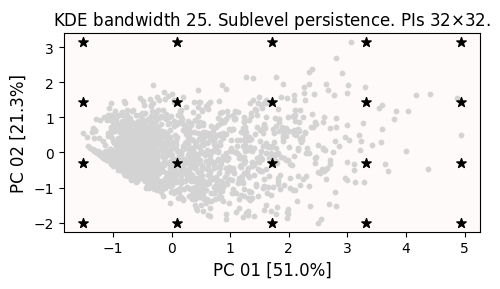

In [8]:
fig, ax = plt.subplots( 1,1, figsize=(5, 3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].set_title(Bname, fontsize=fs)
ax[i].scatter(pca[:,0], pca[:,1], c='lightgray', marker='o', s=10, alpha=1, zorder=1)
ax[i].scatter(grid[:,0], grid[:,1], c='k', marker='*', s=50, alpha=1, zorder=2)
ax[i].set_xlabel('PC 01 [{:.1f}%]'.format(explained_ratio[0]), fontsize=fs)
ax[i].set_ylabel('PC 02 [{:.1f}%]'.format(explained_ratio[1]), fontsize=fs)
ax[i].set_facecolor('snow')

fig.tight_layout();

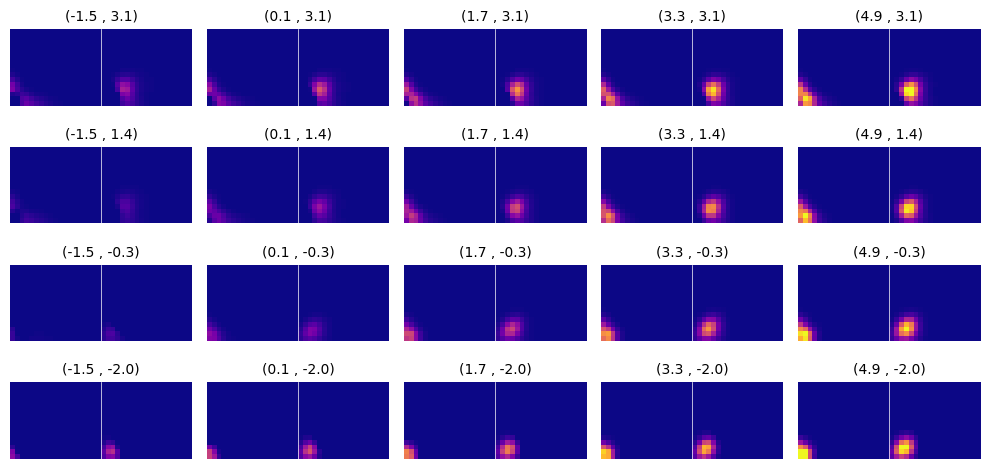

In [9]:
fig, ax = plt.subplots( 4, 5, figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel();
for i in range(len(inv)):
    bar = inv[i].reshape(len(hdims), Full_img.shape[2], Full_img.shape[3])
    bar = np.hstack([ bar[k].T for k in range(len(bar)) ])
    ax[i].imshow(bar, cmap='plasma', vmin=0, vmax=vmax, origin='lower')
    ax[i].set_title('({:.1f} , {:.1f})'.format(*grid[i, :2]), fontsize=10)
    for k in range(1, len(hdims)):
        ax[i].axvline(k*Full_img.shape[2] - .5, c='white', lw=0.5)
    ax[i].axis('off')
fig.tight_layout();

# Synthetic cells

In [10]:
foo = np.argsort(((metacell['length'] * metacell['height'] - metacell['total_area'])/(metacell['length'] * metacell['height']).values).values)
foo = metacell.iloc[foo]
foo[foo['length'] > 500].head(10)

,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,number_nuclei,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID
ndimage_cellID,,,,,,,,,,,,,,,,
1383,5544,6187,8325,8729,643,404,188236,944,187292,0.994985,0,5850.77,8518.92,5850.32,8518.45,1384
51,9729,10249,2067,2501,520,434,163095,0,163095,1.000000,0,9991.74,2282.72,9991.24,2282.20,51
877,5552,6125,6209,6508,573,299,121722,0,121722,1.000000,0,5828.98,6355.38,5828.52,6354.94,878
888,1270,1773,6261,6670,503,409,146056,3191,142865,0.978152,3,1534.11,6454.95,1533.64,6454.48,888
632,6174,6682,5124,5528,508,404,145434,4659,140775,0.967965,1,6436.83,5323.11,6436.30,5322.62,633
2205,11391,11915,11783,12222,524,439,162643,0,162643,1.000000,0,11651.10,12003.18,11650.67,12002.69,2206
1431,3837,4444,8533,8907,607,374,160115,6170,153945,0.961465,1,4159.96,8709.56,4159.34,8709.05,1432
68,5443,5970,2223,2724,527,501,185950,0,185950,1.000000,0,5673.96,2501.12,5673.58,2500.54,68
743,4928,5440,5609,6027,512,418,150588,5545,145043,0.963178,1,5187.17,5809.31,5186.64,5808.83,744


In [8]:
cidx = 51

cell, extent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=False)
cell[pxbar] = -1
com = np.hstack( [metacell.loc[cidx, ['ndimage_comX','ndimage_comY']].values, zmax/2])
axes, ogrid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, cell, extent, zmax, stepsize, cell_nuc)

In [9]:
sig, N = 10, 1
coms = []
rang = range(-5,6,2)
for y in rang:
    coms += [ com +  rng.normal(2.5, 1, 1)[0]*bw*np.array([x,y,0]) for x in rang ]
for y in rang:
    coms += [ com +  rng.normal(2.5, 1, 1)[0]*bw*np.array([x+1,y+1,0]) for x in rang ]
coms = np.array(coms)
n = np.linalg.norm(coms - com, axis=1)
coms = coms[np.argsort(n)]
n = np.sort((n//5).astype(int))[::-1]

sigs = np.arange(0,30,5)
sigs[0] = 1

KDE, hcoords, hrho, hds, hlt, hpi, hpc = [ [None for _ in range(len(sigs))] for _ in range(7) ]

for s in range(len(sigs)):
    synth_c = np.empty((0,3))
    for i,mu in enumerate(coms[:sigs[s]]):
        synth_c = np.vstack( [synth_c , rng.normal( mu, [sigs[s], sigs[s], 1], (N+n[2*sigs[s]], 3) )] )
    synth_c = synth_c.astype(int).T
    synth_c = synth_c[:, label[synth_c[1], synth_c[0]] == cidx]
    hcoords[s] = synth_c
    hrho[s] = 1e4*len(hcoords[s][0])/metacell.loc[cidx, 'cyto_area']
    print(synth_c.shape)

(3, 119)
(3, 455)
(3, 720)
(3, 915)
(3, 919)
(3, 929)


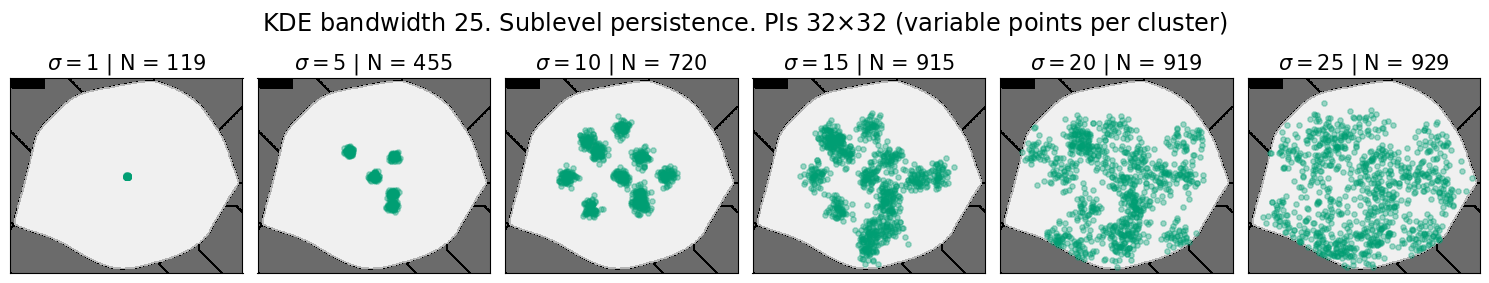

In [10]:
fs = 15
fig, ax = plt.subplots( 1, 6, figsize=(15, 3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for i in range(len(hcoords)):
    ax[i].imshow(cell+1, cmap=cellular_cmap, origin='lower', extent=extent, vmin=0, vmax=nnuc+2, zorder=1);
    ax[i].set_facecolor(wong[2])
    ax[i].scatter(hcoords[i][0], hcoords[i][1], color=color[1], marker=marker[1], alpha=0.35, s=int(4e6/cell.size), zorder=3)
    ax[i].set_title('$\\sigma = ${} | N = {}'.format(sigs[i], len(hcoords[i][0])), fontsize=fs)
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[i].set_aspect('equal')

if N < 2:
    title = Bname[:-1] + ' (variable points per cluster)'
    filename = dsrc + bname + pname + '_synthetic_negvarclusters.jpg'
else:
    title = Bname[:-1] + ' ({} points per cluster)'.format(N)
    filename = dsrc + bname + pname + '_synthetic_{}_clusters.jpg'.format(N)

fig.suptitle(title, fontsize=1.15*fs)
fig.tight_layout()
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

In [11]:
for s in range(len(hcoords)):
    synth_c = hcoords[s]
    r = len(synth_c[0])/np.sum(transfocus.values, axis=None)

    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(synth_c.T).evaluate(ogrid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(synth_c)))
    kde[outside_walls] = 0
    kde = kde/(np.sum(kde)*(stepsize**len(synth_c)))
    kde = kde.reshape( list(map(len, axes))[::-1], order='F')
    
    cc = gd.CubicalComplex(top_dimensional_cells = utils.get_level_filtration(kde, level) )
    pers = cc.persistence(homology_coeff_field=2, min_persistence=1e-15)   
    diag = utils.pers2numpy(pers)
    
    ds = [np.empty((0,2)) for k in range(ndims)]
    lt = [np.empty((0,2)) for k in range(ndims)]
    
    for k in range(ndims):
        ds[k] = diag[diag[:,0] == k, 1:]
        ds[k]  = np.atleast_2d(ds[k][np.all(ds[k] < np.inf, axis=1), :].squeeze())
        ds[k] *= r*rescale
        lt[k] = np.column_stack( (ds[k][:, 0], ds[k][:, 1] - ds[k][:, 0])  )
    
    img = np.asarray(pimgr.transform(lt, skew=False))
    img[img < 0] = 0

    pi = (img[hdims]).ravel(order='C') 
    pc = PCA.transform( (pi - scaler.mean_).reshape(1,-1)).squeeze()
    
    KDE[s], hcoords[s], hds[s], hlt[s], hpi[s], hpc[s] = kde*r, synth_c, ds, lt, img, pc
    print(sigs[s])

hpc = np.asarray(hpc)

1
5
10
15
20
25


os.pardir/infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale32_-_PI_1_1_1_H1+2_synthetic_varclusters2.jpg


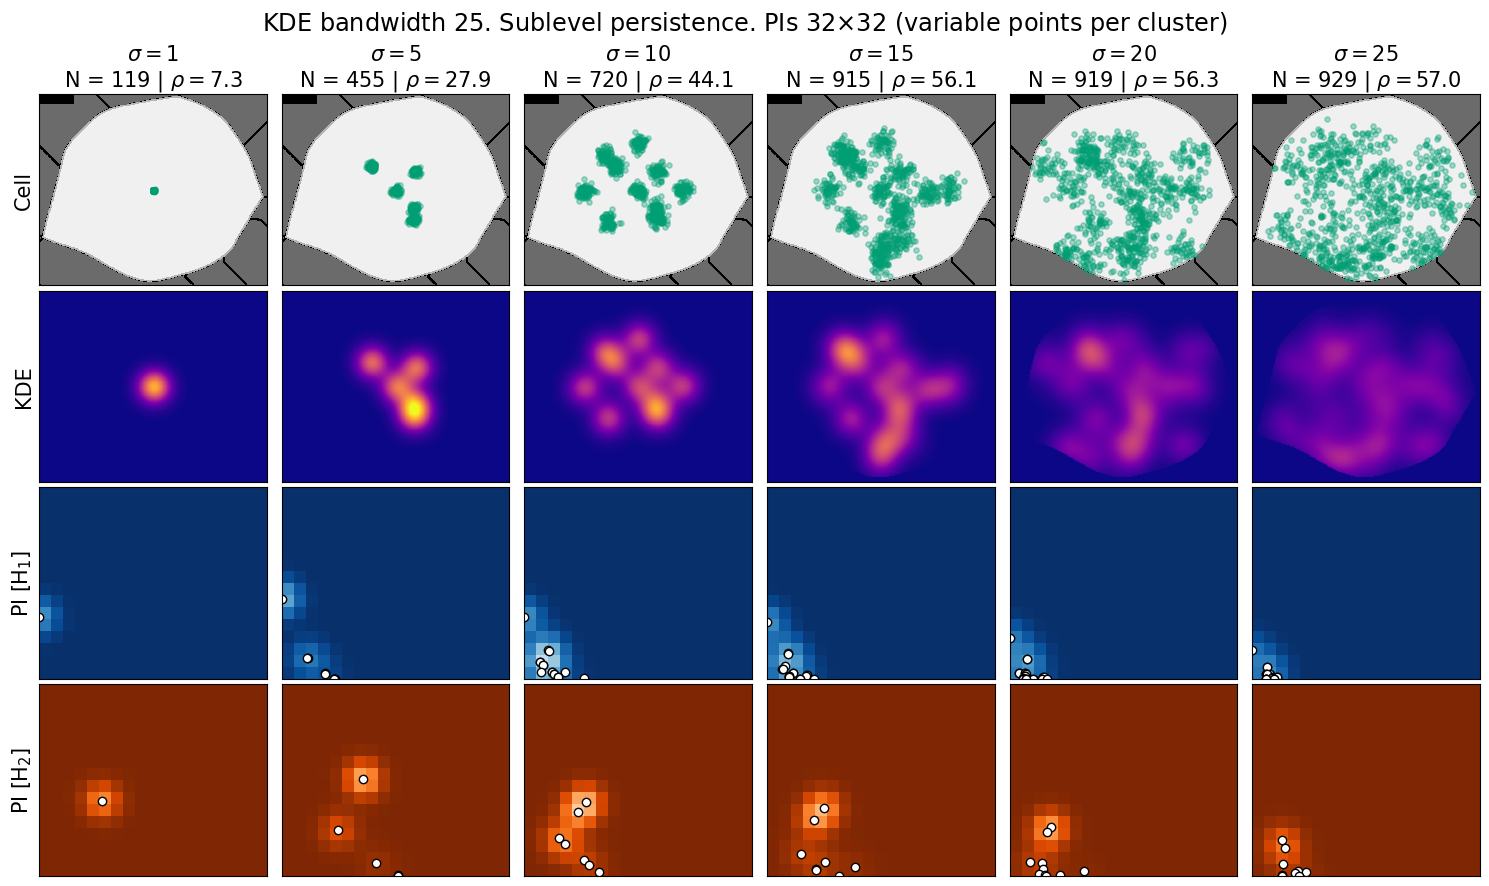

In [51]:
fs = 15
fig, ax = plt.subplots( 4, 6, figsize=(15, 9), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

for i in range(len(hcoords)):
    ax[i].imshow(cell+1, cmap=cellular_cmap, origin='lower', extent=extent, vmin=0, vmax=nnuc+2, zorder=1);
    ax[i].set_facecolor(wong[2])
    ax[i].scatter(hcoords[i][0], hcoords[i][1], color=color[1], marker=marker[1], alpha=0.35, s=int(4e6/cell.size), zorder=3)
    ax[i].set_title('$\\sigma = ${}\nN = {} | $\\rho =${:.1f}'.format(sigs[i], len(hcoords[i][0]), hrho[i]), fontsize=fs)
    
    j = len(hcoords) + i
    ax[j].imshow(np.max(KDE[i], axis=0), origin='lower', cmap=Cmap, vmin=0, vmax=kmax, zorder=1, extent=extent)

    for k in [1,2]:
        j = (k+1)*len(hcoords) + i
        ax[j].imshow(hpi[i][k].T, origin='lower', cmap=cmap[k+1], vmin=0, vmax=pivmax, zorder=1, extent=piextent)
        ax[j].scatter(*hlt[i][k].T, c='w', marker='o', edgecolor='k')

for i in range(len(ax)):
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[i].set_aspect('equal')

ylabel = ['Cell', 'KDE', 'PI [H$_1$]', 'PI [H$_2$]']
for i,j in enumerate(range(0, len(ax), len(hcoords))):
    ax[j].set_ylabel(ylabel[i], fontsize=fs)

if N < 2:
    title = Bname[:-1] + ' (variable points per cluster)'
    filename = dsrc + bname + pname + '_synthetic_varclusters2.jpg'
else:
    title = Bname[:-1] + ' ({} points per cluster)'.format(N)
    filename = dsrc + bname + pname + '_synthetic_{}_clusters.jpg'.format(N)

fig.suptitle(title, fontsize=1.15*fs)
fig.tight_layout()
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

os.pardir/infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale32_-_PI_1_1_1_H1+2_synthetic_pca_varclusters2.jpg


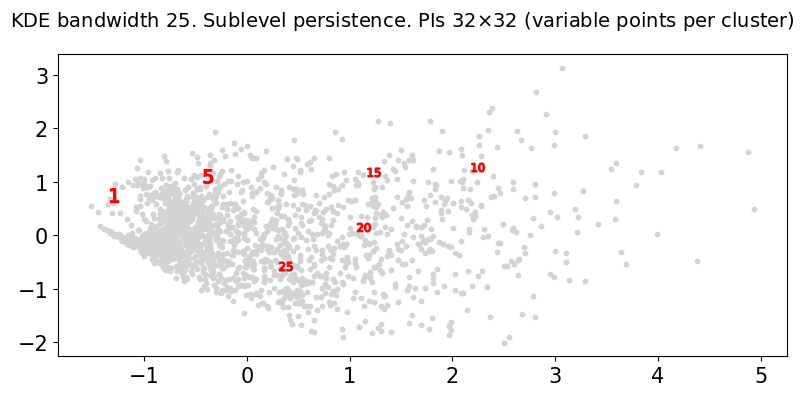

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(pca[:,0], pca[:,1], c='lightgray', marker='o', s=10, alpha=1, zorder=1)
for j in range(len(hpc)):
    ax[i].scatter(hpc[j,0], hpc[j,1], c='r', marker='${{{}}}$'.format(sigs[j]), s=100, alpha=1, zorder=3)

for i in range(len(ax)):
    ax[i].tick_params(labelsize=fs)
fig.suptitle(title, fontsize=14)
fig.tight_layout()

if N < 2:
    filename = dsrc + bname + pname + '_synthetic_pca_varclusters2.jpg'
else:
    filename = dsrc + bname + pname + '_synthetic_pca_{}_clusters.jpg'.format(N)

print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

In [55]:
i = 2
norm = np.linalg.norm(pca - hpc[i], axis=1)
idx = np.argmin(norm)
tidx, cidx = bsummary.iloc[idx].values
print(np.min(norm), np.round(hpc[i],2), np.round(pca[idx],2), np.round((hpc[i]-pca[idx])**2, 2))

1.0947369436975734 [ 2.23  1.29  0.1   1.08  0.61 -1.5 ] [ 1.81  1.24  0.85  0.76  0.08 -1.23] [0.18 0.   0.57 0.1  0.27 0.07]


In [56]:
ocell, oextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=False)
ocell[pxbar] = -1
axes, ogrid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, ocell, oextent, zmax, stepsize, cell_nuc)

cmask = label[ translocs[tidx]['Y'], translocs[tidx]['X'] ] == cidx
coords = translocs[tidx].iloc[cmask].values.T
rho = 1e4*len(coords[0])/metacell.loc[cidx, 'cyto_area']


kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T).evaluate(ogrid)
kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(coords)))
kde[outside_walls] = 0
kde = kde/(np.sum(kde)*(stepsize**len(coords)))
kde = kde.reshape( list(map(len, axes))[::-1], order='F')
kde *= ratios[invGenes[tidx]][ invCells[cidx] ]

os.pardir/infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale32_-_PI_1_1_1_H1+2_synthetic_s10_N1_similar.jpg


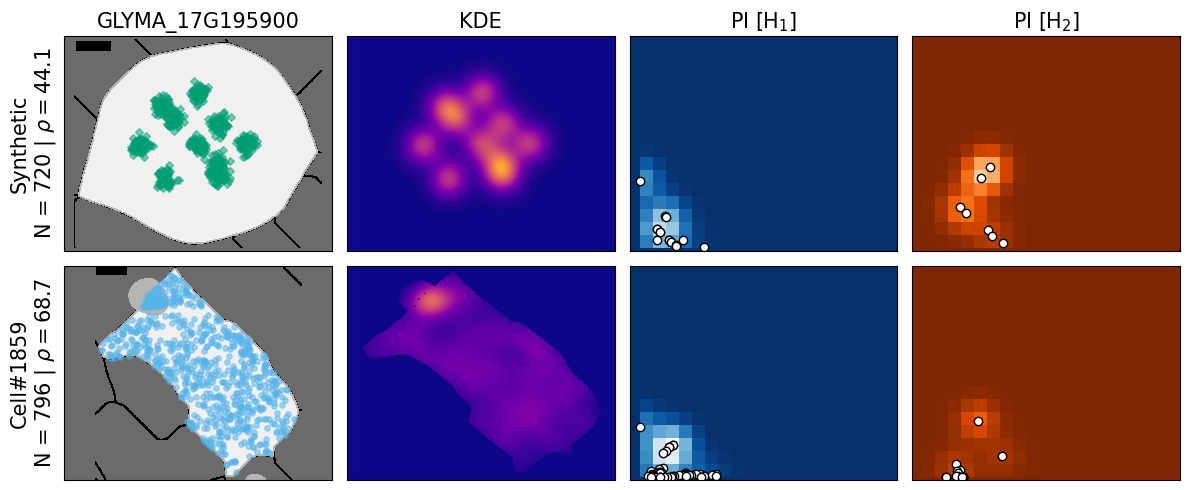

In [57]:
fig, ax = plt.subplots( 2, 4, figsize=(12,5), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); j = 0

title = ['Synthetic\nN = {} | $\\rho =${:.1f}'.format(len(hcoords[i][0]), hrho[i]), 
         'Cell#{}\nN = {} | $\\rho =${:.1f}'.format(cidx, len(coords[0]), rho)]

ylabel = [transcriptomes[tidx], 'KDE']
for j, (cll,coor,ext) in enumerate(zip([cell,ocell],[hcoords[i],coords],[extent,oextent])):
    k = 4*j
    ax[k].imshow(cll+1, cmap=cellular_cmap, origin='lower', extent=ext, vmin=0, vmax=nnuc+2, zorder=1);
    ax[k].set_facecolor(wong[2])
    ax[k].scatter(coor[0], coor[1], color=color[1-j], marker=marker[j], alpha=0.5, s=int(4e6/cell.size), zorder=3)
    ax[k].set_ylabel(title[j], fontsize=fs)
    #ax[j].set_aspect('equal', 'datalim')
    #ax[2*j].set_ylabel(ylabel[j], fontsize=fs)

for j, (kd,ext) in enumerate(zip([KDE[i], kde],[extent,oextent])):
    k = 4*j + 1
    ax[k].imshow(np.max(kd, axis=0), origin='lower', cmap=Cmap, vmin=0, vmax=kmax, zorder=1, extent=extent)
    ax[k].set_facecolor( mpl.colormaps[ Cmap ](0) )

for kk in [1,2]:
    for j, (kd,ext) in enumerate(zip([hpi[i][kk], Full_img[kk][idx]],[hlt[i][kk], full_lt_coll[kk][idx]])):
        k = 4*j + kk + 1
        ax[k].imshow(kd.T, origin='lower', cmap=cmap[kk+1], vmin=0, vmax=pivmax, zorder=1, extent=piextent)
        ax[k].scatter(*ext.T, c='w', marker='o', edgecolor='k')
        ax[k].set_facecolor( mpl.colormaps[ cmap[kk+1] ](0) )

title = [transcriptomes[tidx], 'KDE', 'PI [H$_1$]', 'PI [H$_2$]'] + ['' for _ in range(len(ax))]
for j in range(len(ax)):
    ax[j].set_title(title[j], fontsize=fs)
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[j].set_aspect('equal', 'datalim')

fig.align_labels(ax)
fig.tight_layout()
filename = dsrc + bname + pname + '_synthetic_s{}_N{}_similar.jpg'.format(sigs[i], N)
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

In [47]:
np.sum(np.abs(loadings[:,k]) < 1e-10)/loadings[:,k].size

0.4243421052631579

In [29]:
k = 0
ll = loadings[:,0].reshape( len(hdims)*Full_img.shape[2], Full_img.shape[3], order='C').T

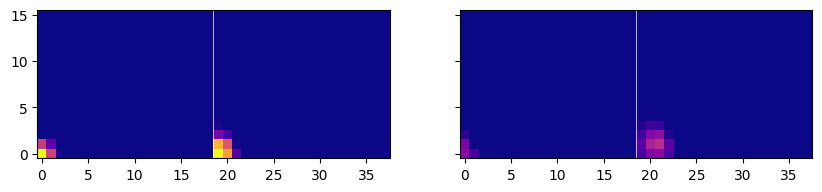

In [953]:
fig, ax = plt.subplots( 1, 2, figsize=(10,5), sharex=True, sharey=True)

i = 0
ax[i].imshow(np.hstack([ img[k].T for k in range(len(img)) ]), cmap='plasma', vmin=0, vmax=vmax, origin='lower')

i = 1
bar = inv[15].reshape(len(hdims), Full_img.shape[2], Full_img.shape[3])
bar = np.hstack([ bar[k].T for k in range(len(bar)) ])
ax[i].imshow(bar, cmap='plasma', vmin=0, vmax=vmax, origin='lower')

for i in range(len(ax)):
    ax[i].set_facecolor( mpl.colormaps[ Cmap ](0) )
    for k in range(1, len(hdims)):
        ax[i].axvline(k*Full_img.shape[2] - .5, c='white', lw=0.5)

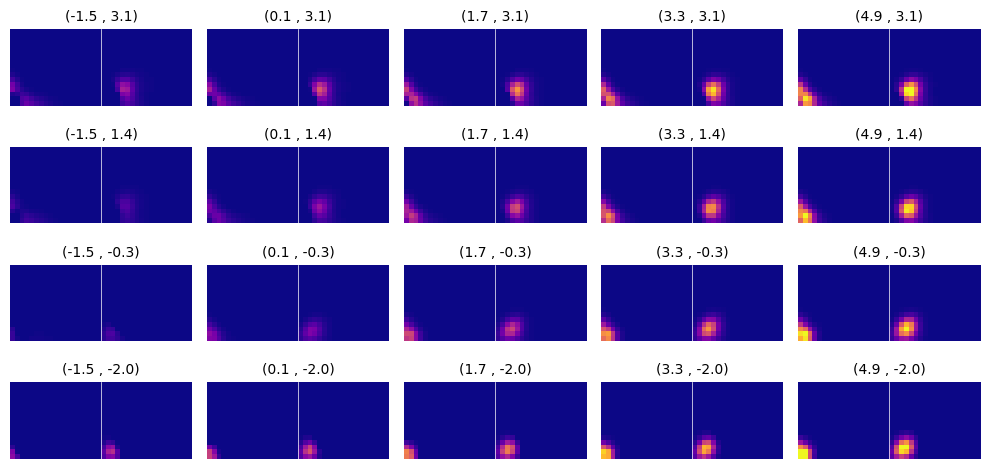

In [803]:
fig, ax = plt.subplots( 4, 5, figsize=(10,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel();
for i in range(len(inv)):
    bar = inv[i].reshape(len(hdims), Full_img.shape[2], Full_img.shape[3])
    bar = np.hstack([ bar[k].T for k in range(len(bar)) ])
    ax[i].imshow(bar, cmap='plasma', vmin=0, vmax=vmax, origin='lower')
    ax[i].set_title('({:.1f} , {:.1f})'.format(*grid[i, :2]), fontsize=10)
    for k in range(1, len(hdims)):
        ax[i].axvline(k*Full_img.shape[2] - .5, c='white', lw=0.5)
    ax[i].axis('off')
fig.tight_layout();

# Locally Linear Embeddings